In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
%pip install transformers trl wandb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from tqdm import tqdm
import pandas as pd

tqdm.pandas()

from transformers import pipeline, AutoTokenizer
from datasets import load_dataset

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/jayicebear/.local/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /home/sw/spack/opt/spack/linux-ubuntu22.04-x86_64_v3/gcc-11.4.0/cuda-11.8.0-pfc6itin63yafh5iqlnuuzfopjbo2irw/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.9
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /home/jayicebear/.local/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/home/jayicebear/.local/lib/python3.11/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/cuda/lib')}
  warn(msg)


In [11]:
config = PPOConfig(
    model_name="lvwerra/gpt2-imdb",
    learning_rate=1.41e-5,
    log_with="wandb",
)

sent_kwargs = {"return_all_scores": True, "function_to_apply": "none", "batch_size": 16}

In [8]:
import wandb

wandb.init()

wandb: Currently logged in as: leejimin1690 (jaylee_kr). Use `wandb login --relogin` to force relogin


In [15]:
def build_dataset(config, dataset_name="imdb", input_min_text_length=2, input_max_text_length=8):
    """
    Build dataset for training. This builds the dataset from `load_dataset`, one should
    customize this function to train the model on its own dataset.

    Args:
        dataset_name (`str`):
            The name of the dataset to be loaded.

    Returns:
        dataloader (`torch.utils.data.DataLoader`):
            The dataloader for the dataset.
    """
    tokenizer = AutoTokenizer.from_pretrained(config.model_name)
    tokenizer.pad_token = tokenizer.eos_token
    # load imdb with datasets
    ds = load_dataset(dataset_name, split="train")
    ds = ds.rename_columns({"text": "review"})
    ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample
 
    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")
    return ds

In [16]:
dataset = build_dataset(config)


def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

In [12]:
model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)
ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)
tokenizer = AutoTokenizer.from_pretrained(config.model_name)

tokenizer.pad_token = tokenizer.eos_token

In [17]:
ppo_trainer = PPOTrainer(config, model, ref_model, tokenizer, dataset=dataset, data_collator=collator)

In [21]:
device = ppo_trainer.accelerator.device
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu"  # to avoid a `pipeline` bug
sentiment_pipe = pipeline("sentiment-analysis", model="lvwerra/distilbert-imdb", device=device)

In [23]:
gen_kwargs = {"min_length": -1, "top_k": 0.0, "top_p": 1.0, "do_sample": True, "pad_token_id": tokenizer.eos_token_id}

In [12]:
output_min_length = 4
output_max_length = 16
output_length_sampler = LengthSampler(output_min_length, output_max_length)


generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
}


for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    query_tensors = batch["input_ids"]

    #### Get response from gpt2
    response_tensors = []
    for query in query_tensors:
        gen_len = output_length_sampler()
        generation_kwargs["max_new_tokens"] = gen_len
        response = ppo_trainer.generate(query, **generation_kwargs)
        response_tensors.append(response.squeeze()[-gen_len:])
    batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

    #### Compute sentiment score
    texts = [q + r for q, r in zip(batch["query"], batch["response"])]
    pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
    rewards = [torch.tensor(-(output[1]["score"])) for output in pipe_outputs]

    #### Run PPO step
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)
    ppo_trainer.log_stats(stats, batch, rewards)

0it [00:00, ?it/s]/home/jayicebear/.local/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/jayicebear/snap/trl/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (37.28) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/jayicebear/snap/trl/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (34.73) exceeds threshold 10.00. Skipping batch.
  warnings.warn(
/home/jayicebear/snap/trl/trl/trainer/ppo_trainer.py:1200: UserWarning: The average ratio of batch (18.82) exceeds t

In [24]:
#### get a batch from the dataset
bs = 500
output_min_length = 4
output_max_length = 16
output_length_sampler = LengthSampler(output_min_length, output_max_length)

game_data = dict()
dataset.set_format("pandas")
df_batch = dataset[:].sample(bs)
game_data["query"] = df_batch["query"].tolist()
query_tensors = df_batch["input_ids"].tolist()

response_tensors_ref, response_tensors = [], []

#### get response from gpt2 and gpt2_ref
for i in range(bs):
    gen_len = output_length_sampler()
    output = ref_model.generate(
        torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device), max_new_tokens=gen_len, **gen_kwargs
    ).squeeze()[-gen_len:]
    response_tensors_ref.append(output)
    output = model.generate(
        torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device), max_new_tokens=gen_len, **gen_kwargs
    ).squeeze()[-gen_len:]
    response_tensors.append(output)

#### decode responses
game_data["response (before)"] = [tokenizer.decode(response_tensors_ref[i]) for i in range(bs)]
game_data["response (after)"] = [tokenizer.decode(response_tensors[i]) for i in range(bs)]

#### sentiment analysis of query/response pairs before/after
texts = [q + r for q, r in zip(game_data["query"], game_data["response (before)"])]
game_data["rewards (before)"] = [output[1]["score"] for output in sentiment_pipe(texts, **sent_kwargs)]

texts = [q + r for q, r in zip(game_data["query"], game_data["response (after)"])]
game_data["rewards (after)"] = [output[1]["score"] for output in sentiment_pipe(texts, **sent_kwargs)]

# store results in a dataframe
df_results = pd.DataFrame(game_data)
df_results

/home/jayicebear/.local/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


,query,response (before),response (after),rewards (before),rewards (after)
0,Of all Arnold,"'s roles, he boasts actors like Victor Scent",", this is the worst film I have ever seen",2.052601,-2.875371
1,i watched this series when it,was available and I'd been looking for anothe...,was awful Bill Martin. The screen was horribl...,1.500073,-2.761214
2,There's nothing quite like watching giant,hairy apes feces on a threadbare wooden table...,balls of one kind and one of the worst series...,-2.394982,-2.908708
3,A community pool in Connecticut is,a very good idea at the moment where this pro...,"not not a good movie, and is not a good movie",2.048237,-2.571473
4,The movie,abdyll ses Here,is awful. You couldn't,-0.692668,-2.898388
...,...,...,...,...,...
495,After seeing,USA once he questions the use of police and i...,this horrible film I was disgusted by the sho...,-0.576034,-2.563978
496,This is a very engross,"ing story of a highly active, hugely",ing list of worst movie I've ever,2.820065,-2.579053
497,The combination of,"shoddy quality, poor funding","the horrible script, and the",-2.752150,-2.799134
498,Greg Davis and,Jennifer Granville as a,her assistant couldn't contain,0.462964,-2.297561


In [14]:
print("mean:")
display(df_results[["rewards (before)", "rewards (after)"]].mean())
print()
print("median:")
display(df_results[["rewards (before)", "rewards (after)"]].median())

mean:


rewards (before)   -0.479662
rewards (after)    -2.442306
dtype: float64


median:


rewards (before)   -0.446119
rewards (after)    -2.808923
dtype: float64

In [15]:
model.save_pretrained("gpt2-imdb-negative-v2", push_to_hub=True)
tokenizer.save_pretrained("gpt2-imdb-negative-v2", push_to_hub=True)

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

('gpt2-imdb-negative-v2/tokenizer_config.json',
 'gpt2-imdb-negative-v2/special_tokens_map.json',
 'gpt2-imdb-negative-v2/vocab.json',
 'gpt2-imdb-negative-v2/merges.txt',
 'gpt2-imdb-negative-v2/added_tokens.json',
 'gpt2-imdb-negative-v2/tokenizer.json')

In [17]:
from transformers import RobertaTokenizer,RobertaForSequenceClassification
toxicity_model_id = "facebook/roberta-hate-speech-dynabench-r4-target"
toxicity_tokenizer = RobertaTokenizer.from_pretrained(toxicity_model_id)
toxicity_model = RobertaForSequenceClassification.from_pretrained(toxicity_model_id, torch_dtype=torch.float16).to(
    ppo_trainer.accelerator.device
)

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [19]:
device = ppo_trainer.accelerator.device
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu"  # to avoid a `pipeline` bug
hate_pipe = pipeline("sentiment-analysis", model="facebook/roberta-hate-speech-dynabench-r4-target", device=device)

In [34]:
hate_pipe('what i want for christmas is not you')

[{'label': 'nothate', 'score': 0.9958207607269287}]

In [37]:
df_results.response (before)

Index(['query', 'response (before)', 'response (after)', 'rewards (before)',
       'rewards (after)'],
      dtype='object')

In [61]:
toxic_score_before = 0
toxic_score_after = 0

for i in range(len(df_results)):
    toxic_score_before += hate_pipe(df_results['response (before)'][i])[0]['score']
    toxic_score_after += hate_pipe(df_results['response (after)'][i])[0]['score']

/home/jayicebear/.local/lib/python3.11/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [70]:
hate_pipe(df_results['response (before)'][0])

/home/jayicebear/.local/lib/python3.11/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


[{'label': 'nothate', 'score': 0.6106754541397095}]

In [66]:
print("before toxic mean:",toxic_score_before/500)

before toxic mean: 0.9897023351192474


In [67]:
print("after toxic mean:",toxic_score_after/500)

after toxic mean: 0.9095597826242446


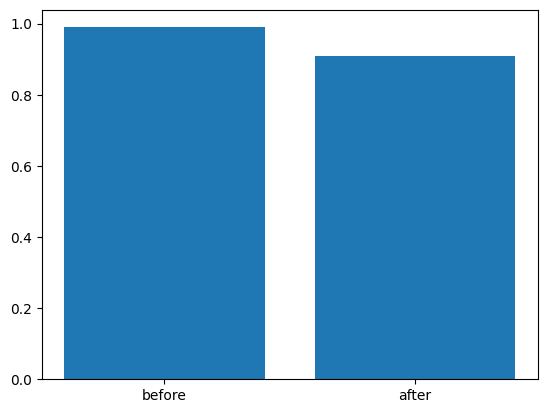

In [69]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(2)
years = ['before','after']
values = [toxic_score_before/500,toxic_score_after/500]

plt.bar(x, values)
plt.xticks(x, years)

plt.show()

In [25]:
model = AutoModelForCausalLMWithValueHead.from_pretrained("Jayicebear/gpt2-imdb-negative-v2")
tokenizer = AutoTokenizer.from_pretrained('Jayicebear/gpt2-imdb-negative-v2')

Some weights of the model checkpoint at Jayicebear/gpt2-imdb-negative-v2 were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
hate_pipe('fuck')

[{'label': 'LABEL_1', 'score': 0.526710033416748}]